# Symmetric Image generation from MNIST dataset

*Gonzalo Muradas and Arthur Tavares - 02/2023*

This Notebook demonstrates how to process MNIST number images and perform a simple algorithm to generate symmetric images with a randomly selected axis of symmetry.

*Dataset from https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?resource=download*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm

Reading the <code>CSV</coode>

In [2]:
minst = pd.read_csv('MNIST/mnist_test.csv')

<h3>How to load and display the images?</h3>

<code>imshow</code> requires a 2D array representing an image. If image is a flat list, you'll need to reshape it to 2D before passing it to <code>imshow</code>. <code>getImageArray</code> is included in <code>functions.py</code> and it return a uint8 np array with 3 color channel and its label from the selected row number.


Shape: (28, 28, 3)


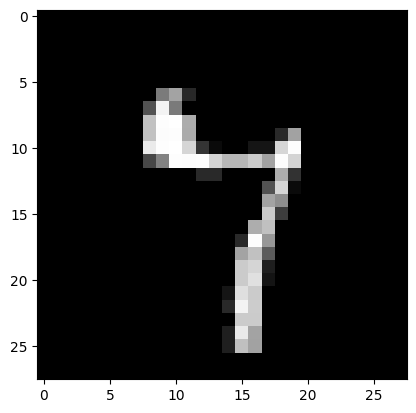

In [3]:
#Returns numpy array of the digit and its label
def getImageArray(id, minst):
    image = minst.iloc[id][1:].values.flatten().tolist()
    array = np.reshape(image, (int(len(image)**0.5),int(len(image)**0.5)))

    return cv2.merge((array,array,array)).astype(np.uint8), minst.iloc[id]['label']

image,_ = getImageArray(2523,minst)

print("Shape:",image.shape)
plt.imshow(image)
plt.show()

<h3>How to rotate the images?</h3>

To rotate an image represented by a numpy matrix in Python without losing quality, you can use the <code>cv2.warpAffine</code> function from the OpenCV library. This function uses affine transformations to rotate images. Eventhough it provides high-quality results even for large rotations, the default interpolation mode introduces some bluring. A possible workaraound involves using the Interpolation flags as listed in the [docs](https://docs.opencv.org/3.1.0/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121)

```python
enum InterpolationFlags { 
    INTER_NEAREST = 0, 
    INTER_LINEAR = 1, 
    INTER_CUBIC = 2, 
    INTER_AREA = 3, 
    INTER_LANCZOS4 = 4, 
    INTER_MAX = 7, 
    WARP_FILL_OUTLIERS = 8, 
    WARP_INVERSE_MAP = 16 
}
```
Function <code>rotateDigit</code> creates and applies a rotation matrix of the desired degrees.

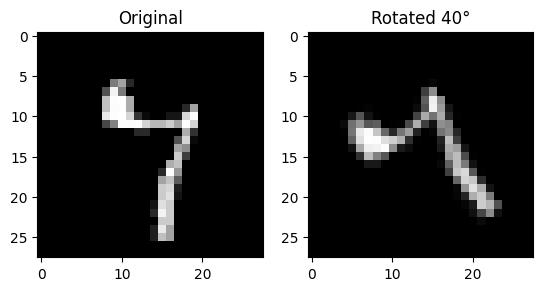

In [4]:
# Returns the rotated image
def rotateDigit(img, degrees):
    height, width = img.shape[:2]
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, degrees, 1)

    return cv2.warpAffine(img, rotation_matrix, (width, height)), rotation_matrix

# Rotate
degrees = 40
rotated_img, rotMatrix = rotateDigit(image, degrees)

# Display
fig, ax = plt.subplots(1,2)
ax[0].imshow(image), ax[0].set_title('Original')
ax[1].imshow(rotated_img), ax[1].set_title(f'Rotated {degrees}°')
plt.show()

<h3>How to produce symmetry?</h3>

After rotating the image, we can select an arbitrary vertical symmetry defined as a point on the x-coordinate set. The following steps summarize the process of creating a symmetrical image from a rotated image using OpenCV:

1. Draw a vertical line on the rotated image with the line's x-coordinate specified by a variable x_sym.

2. Create a copy of the rotated image and flip it along the vertical axis to create a flipped version of the rotated image.

3. Add empty pixel padding to both the rotated image and its flipped version so that their widths match.

4. Finally, add the two padded images together to create a symmetrical image.

Additionally, in the end one can rotate the image back to the original, non-symmetric orientation. This will cause the image to loose more quality.

<h4> Mirroring the image </h4>

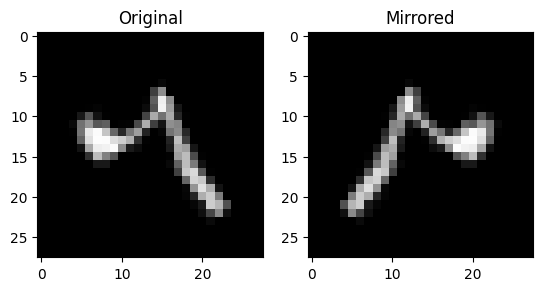

In [5]:
# Mirroring
mirrored = cv2.flip(rotated_img,1)

# Display
fig, ax = plt.subplots(1,2)
ax[0].imshow(rotated_img), ax[0].set_title('Original')
ax[1].imshow(mirrored), ax[1].set_title(f'Mirrored')
plt.show()

<h4>Combining images</h4>

As previously stated, images are stored in 28x28x3 UTF-8 numpy arrays. UTF-8 goes from 0 to 255, if a value surpases 255 it will overflow the variable and return back to 0. The When combining the mirrored images with the original ones, two options arise:

1. Perform the operation with overflow by using the numpy function <code>add()</code>.
2. Perform the operation maintaining the max value of 255 if any pixel surpases it with the function <code>addNoOverflow()</code>

Both options are symmetrical and could add more variety to the random database creation

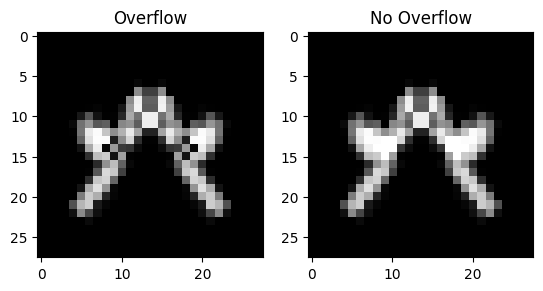

In [6]:
#Returns the combination of the two images with no overflow
def addNoOverflow(img1, img2):
    result = np.zeros(img1.shape, dtype=np.uint8)

    for i in range(len(img1)):
        for j in range(len(img1[0])):
            for x in range(len(img1[0][0])):
                val = int(img1[i][j][x]) + int(img2[i][j][x])
                if val > 255:
                    val = 255
                result[i][j][x] = val

    return result

# Combining
combinationOverflow = np.add(rotated_img,mirrored)
combinationNoOverflow = addNoOverflow(rotated_img,mirrored)

# Display
fig, ax = plt.subplots(1,2)
ax[0].imshow(combinationOverflow), ax[0].set_title('Overflow')
ax[1].imshow(combinationNoOverflow), ax[1].set_title('No Overflow')
plt.show()

<h4>Adding padding</h4>

If no padding is added when combining the images all the digits will be symmetrical with the same axis, this could create a bias for the model. Adding a certain amount of padding to the left and right of the original and mirrored images respectively is done to solve this issue.

The function accepts positive and negative padding.

Shape (28, 36, 3)


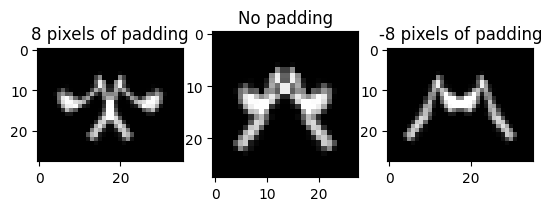

In [7]:
#Returns the combination of img1 and img2 with the selected padding
def addWithPadding(img1,img2,padding,overFlow=False):
    # Create a black pixel column with the same height and color channels as the original image
    black_pixels = np.zeros((img1.shape[0], abs(padding), img1.shape[2])).astype(np.uint8)

    # Concatenate the black pixel column to the left and right of the images
    if padding>=0:
        padded_image1 = np.concatenate((img1, black_pixels), axis=1)
        padded_image2 = np.concatenate((black_pixels,img2), axis=1)
    else:
        padded_image1 = np.concatenate((black_pixels, img1), axis=1)
        padded_image2 = np.concatenate((img2, black_pixels), axis=1)

    #Returns the selected concatenation
    if not overFlow:
        return addNoOverflow(padded_image1,padded_image2)
    else:
        return np.add(padded_image1,padded_image2)

# Combining the images
padding = 8
combinationWithPadding = addWithPadding(rotated_img,mirrored,padding)
combinationWithPaddingNegative = addWithPadding(rotated_img,mirrored,-padding)

# Display
print("Shape",combinationWithPadding.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(combinationWithPadding), ax[0].set_title(f'{padding} pixels of padding')
ax[1].imshow(combinationNoOverflow), ax[1].set_title('No padding')
ax[2].imshow(combinationWithPaddingNegative), ax[2].set_title(f'{-padding} pixels of padding')
plt.show()

<h4> Symmetry axis and Bounding Box </h4>

To label the future database, we will need the keypoints for the segment of the axis of symmetry as well as a bounding box for the symmetric box, calculating this is simple enough, by checking the maximum and minimum X and Y used pixels of the image.

When displaying, the axis of symmetry seems to be a pixel to the left of the actual axis, this is because all the digits have a even number of pixels.

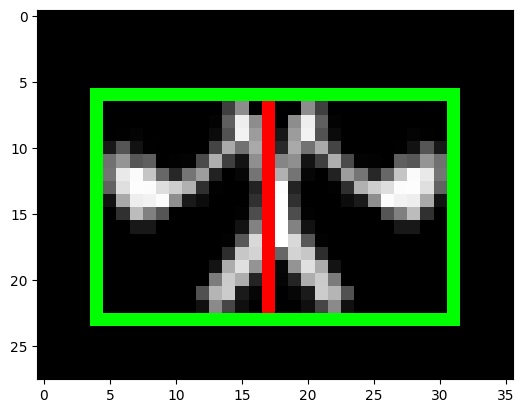

In [8]:
# Returns a list with all the transformmed keypoints
def transformKeypoints(keypoints, rotationMatrix):
    result = []
    for keypoint in keypoints:
        rotatedPoint = rotationMatrix.dot(np.array(keypoint + (1,)))
        result.append((rotatedPoint[0],rotatedPoint[1]))
        
    return result

# Draws rectangle on the image
def displayBoundingBox(img, points):
    cv2.line(img, (int(points[0][0]),int(points[0][1])), (int(points[1][0]),int(points[1][1])), [0,255,0], 1)
    cv2.line(img, (int(points[1][0]),int(points[1][1])), (int(points[2][0]),int(points[2][1])), [0,255,0], 1)
    cv2.line(img, (int(points[2][0]),int(points[2][1])), (int(points[3][0]),int(points[3][1])), [0,255,0], 1)
    cv2.line(img, (int(points[3][0]),int(points[3][1])), (int(points[0][0]),int(points[0][1])), [0,255,0], 1)

# Draws symmetry axis and bounding box
def drawSAandBB(img, startAxis, endAxis, center, width, height, rotation):
    # Symmetry axis
    cv2.line(img, (int(startAxis[0]) , int(startAxis[1])), (int(endAxis[0]) , int(endAxis[1])), [255,0,0], 1)

    # Points for bounding box
    pts = [(center[0]-width/2 , center[1]-height/2), (center[0]+width/2 , center[1]-height/2), 
           (center[0]+width/2 , center[1]+height/2), (center[0]-width/2 , center[1]+height/2)]
    
    # Rotating
    rotationMatrix = cv2.getRotationMatrix2D(center, rotation, 1)
    pts = transformKeypoints(pts, rotationMatrix)

    # Drawing bounding box
    displayBoundingBox(img, pts)
    
# Returns the starting and ending points for the symmetry axis as well as the center, width and height for the bounding box
def getSAandBB(img):
    minX = len(img[0])*10
    minY = -1
    maxX = -1
    maxY = -1
    for i in range(len(img)):
        for j in range(len(img[0])):
            if minY == -1 and (img[i][j][0] != 0 or img[i][j][1] != 0 or img[i][j][2] != 0):
                minY = i
            if img[i][j][0] != 0 or img[i][j][1] != 0 or img[i][j][2] != 0:
                maxY = i-1
                if j-1 > maxX:
                    maxX = j
                if j < minX:
                    minX = j
    maxX += 1
    maxY += 1

    # Axis of symmetry
    startAxis = (minX + (maxX-minX)/2, minY)            
    endAxis = (minX + (maxX-minX)/2, maxY)

    # Center, width and height of bounding box
    center = ((maxX-minX)/2+minX, (maxY-minY)/2+minY)
    height = (maxY-minY)
    width = (maxX-minX)
    
    return startAxis,endAxis,center,width,height

#Calculating axis and bounding box
startAxis, endAxis, center,width,height = getSAandBB(combinationWithPadding)

#Display
displayImg = combinationWithPadding.copy()
drawSAandBB(displayImg, startAxis, endAxis, center, width, height, 0)
plt.imshow(displayImg)
plt.show()

<h4> Final rotation </h4>

Now that the symmetry has been created and labeled it is important to produce one final rotation, otherwise the symmetry axis will always be vertical, creating a bias in the model. 

This presents an issue, if the size of the image is maintained and the symmetry is rotated, it is possible that fragments of the image will be lost.

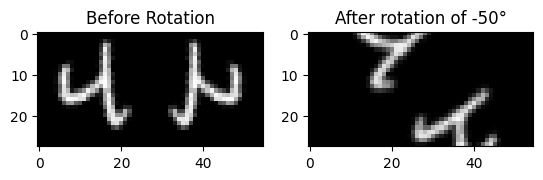

In [9]:
# Performing all operations
badExample,_ = getImageArray(6,minst)
badExample,_ = rotateDigit(badExample, 32)
mirroredBadExample = cv2.flip(badExample,1)
badExample = addWithPadding(badExample,mirroredBadExample, 27)
badExampleRotated,_ = rotateDigit(badExample,-50)

# Display
fig, ax = plt.subplots(1,2)
ax[0].imshow(badExample), ax[0].set_title('Before Rotation')
ax[1].imshow(badExampleRotated), ax[1].set_title('After rotation of -50°')
plt.show()

For this the function <code>addRotationPadding</code> is created, that adds padding on both sides of the image so any rotation can be done without any information loss. With the padding both axis will have the length of the original diagonal.

Note that the symmetry axis and bounding box should be obtained after adding the padding, otherwise the coordinates will not match.

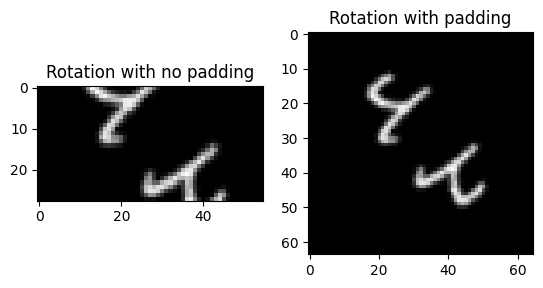

In [10]:
# Adds padding to both axis of the image in order to safely perform rotation
def addRotationPadding(img):
    # Calculating the necessary padding
    height, width = img.shape[:2]
    diagonal = int((height**2+width**2)**0.5)+2
    addWidth = (diagonal-width)//2+1
    addHeight = (diagonal-height)//2+1

    # Applying padding along the X axis
    black_pixels_horizontal = np.zeros((img.shape[0], addWidth, img.shape[2])).astype(np.uint8)

    padded_image = np.concatenate((img, black_pixels_horizontal), axis=1)
    padded_image = np.concatenate((black_pixels_horizontal, padded_image), axis=1)

    # Applying padding along the Y axis
    black_pixels_vertical = np.zeros((addHeight, padded_image.shape[1], img.shape[2])).astype(np.uint8)

    padded_image = np.concatenate((padded_image, black_pixels_vertical), axis=0)
    padded_image = np.concatenate((black_pixels_vertical, padded_image), axis=0)

    return padded_image

# Obtaining safe rotational
safeRotation = addRotationPadding(badExample)
safeRotation,_ = rotateDigit(safeRotation,-50)

# Display
_, ax = plt.subplots(1,2)
ax[0].imshow(badExampleRotated), ax[0].set_title('Rotation with no padding')
ax[1].imshow(safeRotation), ax[1].set_title('Rotation with padding')
plt.show()

<h4>Rotating keypoints</h4>
It is also important to rotate the keypoints as well, for the bounding box as well as the symmetry axis. The function <code>transformKeypoints</code> transforms the keypoints according to a rotation matrix.

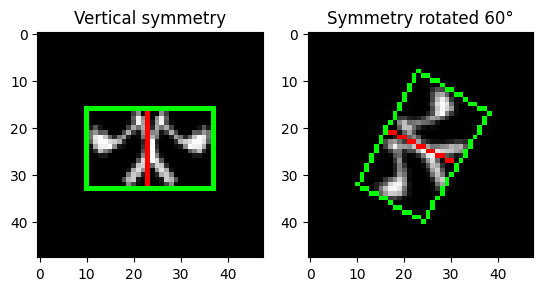

In [11]:
# Padding and keypoints
sRotation = addRotationPadding(combinationWithPadding)
startA, endA, center,width,height = getSAandBB(sRotation)

# Rotating image and keypoints
rotationDegrees = 60
sRotated, rotMat = rotateDigit(sRotation,rotationDegrees)
rotKeypoints = transformKeypoints([startA,endA,center], rotMat)
center = rotKeypoints[2]

# Display
# Before rotation
display1 = sRotation.copy()
drawSAandBB(display1, startA, endA, center, width, height, 0)

# After rotation
display2 = sRotated.copy()
drawSAandBB(display2, rotKeypoints[0], rotKeypoints[1], center, width, height, rotationDegrees)

_, ax = plt.subplots(1,2)
ax[0].imshow(display1), ax[0].set_title('Vertical symmetry')
ax[1].imshow(display2), ax[1].set_title(f'Symmetry rotated {rotationDegrees}°')
plt.show()


<h4>Remove excess padding</h4>
Padding was useful for rotating the digits safely, but now that it is rotated its extra information. <code>removePadding</code> will take care of that. Note that it is important to also update the axis for the symmetry as the resolution of the image changes.

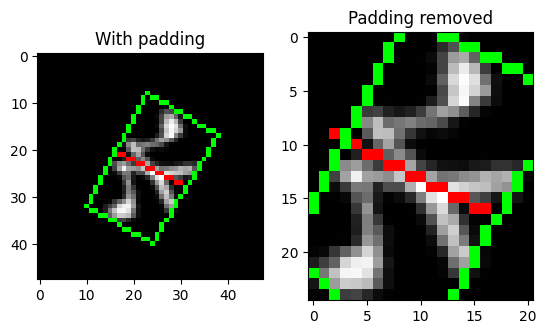

In [12]:
# Remove the excess padding from image
def removePadding(img, startAxis, endAxis, cent):
    _,_, center, width, height = getSAandBB(img)
    minX = int(center[0] - width/2)
    minY = int(center[1] - height/2)
    maxX = int(center[0] + width/2)
    maxY = int(center[1] + height/2)
    cropped = img[minY:maxY, minX:maxX]
    newStartX = startAxis[0] - minX
    newStartY = startAxis[1] - minY
    newEndX = endAxis[0] - minX
    newEndY = endAxis[1] - minY
    newCentX = cent[0] - minX 
    newCentY = cent[1] - minY

    return cropped, (newStartX,newStartY), (newEndX,newEndY), (newCentX, newCentY)

# Cropping
cropped, ns, ne, nc = removePadding(sRotated,rotKeypoints[0],rotKeypoints[1], center)

# Display
display = cropped.copy()
drawSAandBB(display, ns, ne, nc, width, height, rotationDegrees)
_, ax = plt.subplots(1,2)
ax[0].imshow(display2), ax[0].set_title(f'With padding')
ax[1].imshow(display), ax[1].set_title('Padding removed')
plt.show()

<h4>Resizing</h4>
The final operation leaves the symmetry with the smallest possible resolution without information loss. This however can be quite small for a 224x224 image, the smallest resolution used to train a ResNet model. The final operation will resize the image and its keypoints.

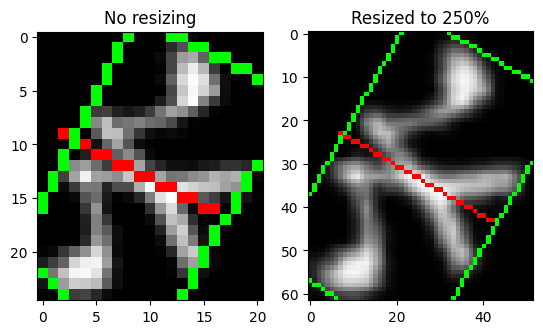

In [13]:
#Resizes the image and keypoints according to the selected percent
def resizeSymmetry(percent, img, startAxis, endAxis, center, inWidth, inHeight):
    width = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)

    newStartX = startAxis[0] * percent / 100
    newStartY = startAxis[1] * percent / 100
    newEndX = endAxis[0] * percent / 100
    newEndY = endAxis[1] * percent / 100
    newCenterX = center[0] * percent / 100
    newCenterY = center[1] * percent / 100
    newWidth = inWidth * percent / 100
    newHeight = inHeight * percent / 100

    return cv2.resize(img, (width, height)), (newStartX,newStartY), (newEndX,newEndY), (newCenterX, newCenterY), newWidth, newHeight

#Resizing
percentage = 250
resizedCropped,rns,rne,rnc,rnw,rnh = resizeSymmetry(percentage, cropped, ns, ne, nc, width, height)

display2 = resizedCropped.copy()
drawSAandBB(display2, rns, rne, rnc, rnw, rnh, rotationDegrees)
_, ax = plt.subplots(1,2)
ax[0].imshow(display), ax[0].set_title(f'No resizing')
ax[1].imshow(display2), ax[1].set_title(f'Resized to {percentage}%')
plt.show()

<h1>!!! PROBLEM AXIS IS DISPLACED WHEN UPSCALE!!!</h1>

(26.5, 18) (26.5, 36)
(79.5, 54.0) (79.5, 108.0)


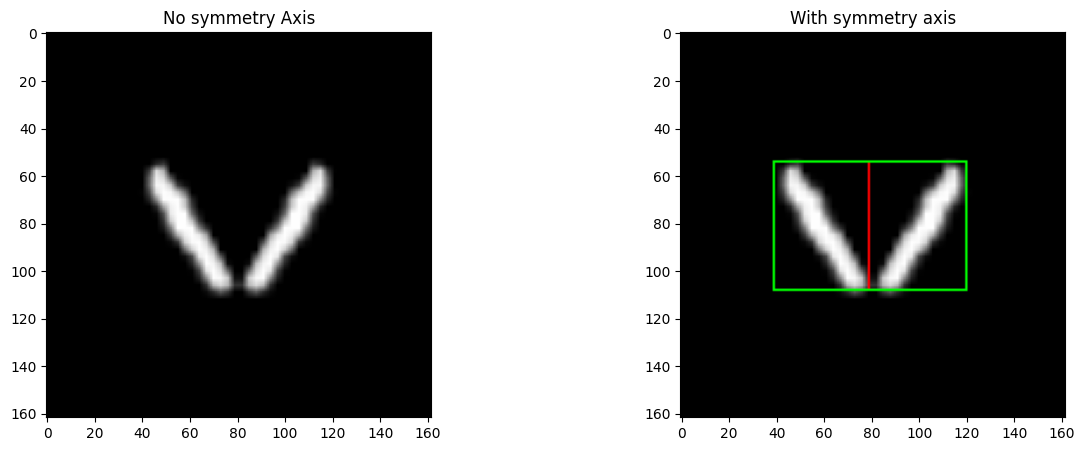

In [14]:
# idx = random.randrange(500)
idx = 329
result,label = getImageArray(idx,minst)
# initRot = random.randrange(360)
initRot = 152
result,_ = rotateDigit(result, initRot)
mirrored = cv2.flip(result, 1)
# pad =  random.randrange(-result.shape[0], result.shape[0])
pad = -14
result = addWithPadding(result,mirrored,pad)
result = addRotationPadding(result)
startAxis, endAxis, center, width, height = getSAandBB(result)
# result, startAxis, endAxis, center = removePadding(result, startAxis, endAxis, center)

print(startAxis,endAxis)
result, startAxis, endAxis, center, width, height = resizeSymmetry(300, result, startAxis, endAxis, center, width, height)
print(startAxis,endAxis)

# Display
display = result.copy()
drawSAandBB(display, startAxis, endAxis, center, width, height, 0)
_, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(result), ax[0].set_title(f'No symmetry Axis')
ax[1].imshow(display), ax[1].set_title(f'With symmetry axis')
plt.show()

<h2>Putting everything together</h2>

After the digit has been resized the generation has been completed. This process is part of a larger script, so it is not combinient to have to call all the functions every time one image wants to be created. The function <code>createSymmetry</code> aims to automate the calling of all functions. The function will apply random rotations and transformations by default but it can be controled by changing its attributes.

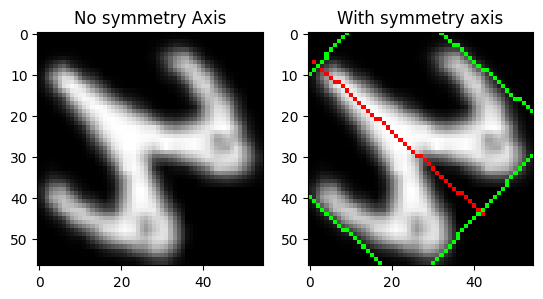

In [19]:
# Creates a random symmetry, returns array with image, its symmetry axis and its label; parameters can be modified.
def createSymmetry(id, minst, initialRotation = None, overFlow = None, padding = None, finalRotation = None, resizingPercent = None):
    # Getting the image and label
    result,label = getImageArray(id,minst)
    
    # Initial rotation
    if initialRotation is None:
        initialRotation = random.randrange(360)
    result,_ = rotateDigit(result, initialRotation)

    # Mirroring the image
    mirrored = cv2.flip(result, 1)

    # Combining initial with mirrored 
    if overFlow is None:
        overFlow = bool(random.getrandbits(1))
    if padding is None:
        padding = random.randrange(-result.shape[0], result.shape[0])
    result = addWithPadding(result,mirrored, padding, overFlow=overFlow)

    # Adding padding for rotation
    result = addRotationPadding(result)

    # Obtaining symmetry axis
    startAxis, endAxis, center, width, height = getSAandBB(result)

    # Final rotation
    if finalRotation is None:
        finalRotation = random.randrange(360)
    result,rotationMatrix = rotateDigit(result,finalRotation)

    # Rotating symmetry axis
    rotated = transformKeypoints([startAxis, endAxis, center], rotationMatrix)
    startAxis = rotated[0]
    endAxis = rotated[1]
    center = rotated[2]

    # Remove excess pading
    result, startAxis, endAxis, center = removePadding(result, startAxis, endAxis, center)

    # Resizing
    if resizingPercent is None:
        resizingPercent = random.randrange(80,300)
    result, startAxis, endAxis, center, width, height = resizeSymmetry(resizingPercent, result, startAxis, endAxis, center, width, height)

    return result, {'startAxis':startAxis, 'endAxis': endAxis, 'center':center, 'width':width, 'height':height, 'label':label, 'initialRotation':initialRotation, 'overFlow':overFlow, 'padding':padding, 'finalRotation':finalRotation, 'resizingPercent':resizingPercent}

# Calling function
img, dict = createSymmetry(6,minst,resizingPercent=250)

# Display
display = img.copy()
drawSAandBB(display, dict['startAxis'], dict['endAxis'], dict['center'], dict['width'], dict['height'], dict['finalRotation'])
_, ax = plt.subplots(1,2)
ax[0].imshow(img), ax[0].set_title(f'No symmetry Axis')
ax[1].imshow(display), ax[1].set_title(f'With symmetry axis')
plt.show()

<h4>Some examples</h4>

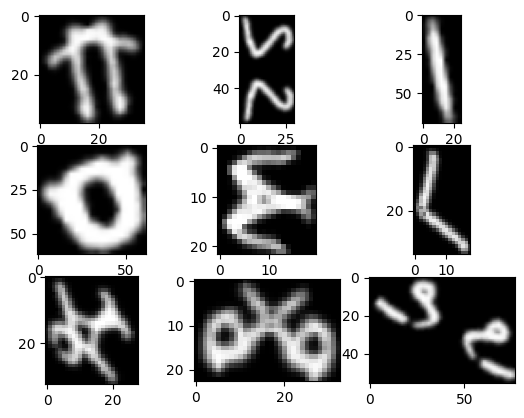

In [16]:
# Generating symmetries
images = []
for i in range(9):
    img, _ = createSymmetry(i, minst)
    images.append(img)

#Displaying them
_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i*3+j])
plt.show()

<h2>Execution time test</h2>

This function has been designed to create a database that will later be used for training a deep learning model. The exectution of the script will only run once, but it is still worth to check what the execution time will be for the dataset. In the code below it is measured how long it will take for the script to generate all 10000 digits stored on the .csv When running it on my computer the execution time was 12 minutes 6 secondes. Creating 13.77 symmetries per second. 

In [17]:
checkTime = False

if checkTime:
    for i in tqdm(range(10000)):
        _,_,_ = createSymmetry(i,minst)

<h2>Assymetry creation</h2>
By modifying the symmetry crearion function and combining two digits it is straightforward to develop a function to create asymetry.

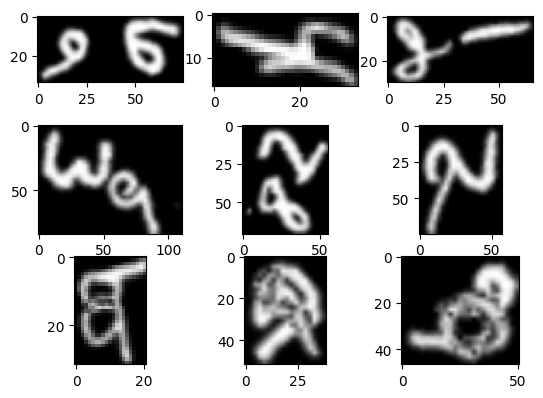

In [22]:
# Creates a random symmetry, returns array with image, its symmetry axis and its label; parameters can be modified.
def createAsymmetry(minst, id1 = None, id2 = None,initialRotation2 = None ,initialRotation1 = None, overFlow = None, padding = None, finalRotation = None, resizingPercent = None):
    # Getting the image and label
    if id1 is None:
        id1 = random.randrange(len(minst))
    if id2 is None:
        id2 = random.randrange(len(minst))
    result, _ = getImageArray(id1,minst)
    otherNumber, _ = getImageArray(id2,minst)
    
    # Initial rotation
    if initialRotation1 is None:
        initialRotation1 = random.randrange(360)
    result,_ = rotateDigit(result, initialRotation1)
    if initialRotation2 is None:
        initialRotation2 = random.randrange(360)
    mirrored,_ = rotateDigit(otherNumber, initialRotation2)

    # Combining initial with the secondNumber 
    if overFlow is None:
        overFlow = bool(random.getrandbits(1))
    if padding is None:
        padding = random.randrange(-result.shape[0], result.shape[0])
    result = addWithPadding(result,mirrored, padding, overFlow=overFlow)

    # Adding padding for rotation
    result = addRotationPadding(result)

    # Final rotation
    if finalRotation is None:
        finalRotation = random.randrange(360)
    result,_ = rotateDigit(result,finalRotation)

    # Remove excess pading
    result, _, _, _ = removePadding(result, (0,0), (0,0), (0,0))

    # Resizing
    if resizingPercent is None:
        resizingPercent = random.randrange(80,300)
    result, _ ,_, _, _, _ = resizeSymmetry(resizingPercent, result, (0,0), (0,0), (0,0), 0, 0)

    return result

# Generating symmetries
images = []
for _ in range(9):
    img = createAsymmetry(minst)
    images.append(img)

#Displaying them
_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i*3+j])
plt.show()